In [1]:
import glob
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
print(tf.__version__)
keras = tf.keras
import matplotlib.pyplot as plt

2.3.0


In [2]:
# train_file_list = glob.glob('./train/*')
train_id_list = [(cv2.imread(_, cv2.IMREAD_GRAYSCALE), int(_.split('_')[-1].split('.')[0][0])) for _ in glob.glob('./train/*')]

# test_file_list = glob.glob('./test/*')
test_id_list = [(cv2.imread(_, cv2.IMREAD_GRAYSCALE), int(_.split('_')[-1].split('.')[0][0])) for _ in glob.glob('./test/*')]

In [3]:
test_id_list

[(array([[38, 37, 36, ..., 48, 46, 45],
         [38, 38, 37, ..., 48, 47, 46],
         [38, 38, 39, ..., 49, 48, 47],
         ...,
         [35, 35, 36, ..., 43, 41, 39],
         [36, 36, 37, ..., 49, 44, 42],
         [36, 37, 38, ..., 51, 46, 43]], dtype=uint8),
  4),
 (array([[43, 43, 43, ..., 43, 43, 42],
         [41, 42, 43, ..., 43, 42, 42],
         [37, 39, 44, ..., 41, 41, 40],
         ...,
         [57, 57, 58, ..., 38, 37, 36],
         [52, 53, 56, ..., 33, 37, 40],
         [49, 51, 55, ..., 30, 38, 42]], dtype=uint8),
  3),
 (array([[42, 43, 44, ..., 45, 49, 50],
         [45, 45, 46, ..., 46, 49, 50],
         [49, 49, 49, ..., 49, 49, 49],
         ...,
         [45, 43, 39, ..., 55, 55, 55],
         [43, 41, 38, ..., 60, 61, 61],
         [42, 40, 38, ..., 62, 64, 64]], dtype=uint8),
  1),
 (array([[38, 40, 45, ..., 48, 51, 52],
         [37, 39, 43, ..., 49, 51, 52],
         [34, 36, 38, ..., 51, 51, 52],
         ...,
         [57, 55, 50, ..., 43, 42, 42],
 

In [4]:
train_X = np.concatenate([np.expand_dims(np.expand_dims(_[0], 0),-1) for _ in train_id_list], 0).astype(float)
train_y = np.concatenate([np.expand_dims(_[1], 0) for _ in train_id_list], 0).astype(float)

test_X = np.concatenate([np.expand_dims(np.expand_dims(_[0], 0),-1) for _ in test_id_list], 0).astype(float)
test_y = np.concatenate([np.expand_dims(_[1], 0) for _ in test_id_list], 0).astype(float)


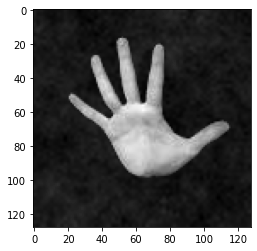

In [5]:
plt.imshow(train_X[0,...,0],cmap='gray')
plt.show()

In [6]:
train_X.shape, train_y.shape

((18000, 128, 128, 1), (18000,))

In [7]:
test_X.shape, test_y.shape

((3600, 128, 128, 1), (3600,))

In [8]:
layers = keras.layers

In [9]:
def create_resnet_id_layer(inputs):
    conv2d = layers.Conv2D(3,(3,3))(inputs)
    bn = layers.BatchNormalization()(conv2d)
    relu = layers.Activation(activation='relu')(bn)
    
    conv2d = layers.Conv2D(3,(3,3))(relu)
    bn = layers.BatchNormalization()(conv2d)
    relu = layers.Activation(activation='relu')(bn)
    
    conv2d = layers.Conv2D(3,(3,3))(relu)
    bn = layers.BatchNormalization()(conv2d)
    
    conv_inputs = layers.Conv2D(3, (7,7))(inputs)
    bn_ci = layers.BatchNormalization()(conv_inputs)
    
    return bn_ci + bn

In [10]:
def invert_colors(image):
    if np.random.uniform() > 0.5:
        image = 255 - image
    return image

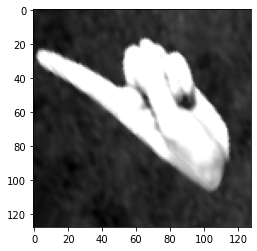

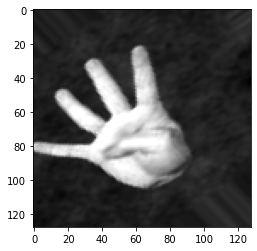

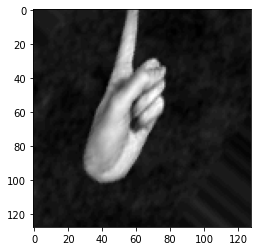

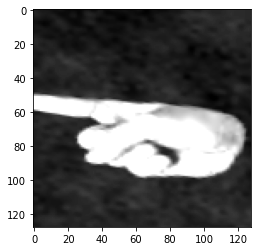

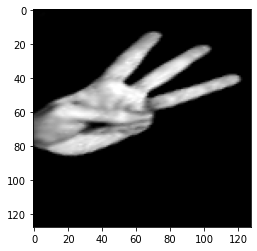

In [13]:
aug = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=90,
    zoom_range=[0.5, 1.0],
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.1,1.5),
    channel_shift_range=100,
    shear_range=30,
    fill_mode="nearest",
    
    validation_split=0.2,
)

x_batch, y_batch = next(aug.flow(train_X, train_y))

for i in range (0,5):
    image = x_batch[i]
    plt.imshow(image, cmap='gray')
    plt.show()

In [14]:

inputs = layers.Input(shape=(128, 128, 1))

# model = keras.Sequential([
#     keras.Input(shape=(128, 128, 1)),
#     layers.Conv2D(3,(3,3), activation='elu'),
#     layers.Conv2D(3,(3,3), activation='elu'),
#     layers.Conv2D(3,(3,3), activation='elu'),
#     layers.MaxPooling2D((3,3)),
#     layers.Conv2D(6,(3,3), activation='elu'),
#     layers.Conv2D(6,(3,3), activation='elu'),
#     layers.Conv2D(6,(3,3), activation='elu'),
#     layers.MaxPooling2D((3,3)),
#     layers.Conv2D(6,(3,3), activation='elu'),
#     layers.Conv2D(6,(3,3), activation='elu'),
#     layers.Conv2D(6,(3,3), activation='elu'),
#     layers.MaxPooling2D((3,3)),
#     layers.Reshape((-1,)),
#     layers.Dense(1, activation='sigmoid')
# ])

a = create_resnet_id_layer(inputs)
# a = layers.AveragePooling2D((2,2))(a)
a = layers.MaxPooling2D((2,2))(a)
relu = layers.Activation(activation='relu')(a)
b = create_resnet_id_layer(relu)
# b = layers.AveragePooling2D((2,2))(b)
b = layers.MaxPooling2D((2,2))(b)
relu = layers.Activation(activation='relu')(b)
c = create_resnet_id_layer(relu)
# c = layers.AveragePooling2D((2,2))(c)
c = layers.MaxPooling2D((2,2))(c)
relu = layers.Activation(activation='relu')(c)
d = create_resnet_id_layer(relu)
# d = layers.AveragePooling2D((2,2))(d)
d = layers.MaxPooling2D((2,2))(d)
relu = layers.Activation(activation='relu')(d)

# a = layers.Conv2D(3,(3,3), activation='elu')(inputs)
rshp = layers.Reshape((-1,))(relu)
outputs = layers.Dense(6, activation='softmax')(rshp)

model = keras.Model(inputs=inputs,outputs=outputs)

model.compile(optimizer="Adam",
              loss="sparse_categorical_crossentropy",
#               callbacks=tf.keras.callbacks.EarlyStopping(
#                   monitor="val_loss",
#                   min_delta=0,
#                   patience=5,
#                   verbose=0,
#                   mode="auto",
#                   restore_best_weights=True),
              metrics=['acc'])

history = model.fit(aug.flow(train_X, train_y, batch_size=32, subset='training'),
          validation_data=aug.flow(train_X, train_y, subset='validation'),
          epochs=50)

Epoch 1/50
450/450 [==============================] - 136s 302ms/step - loss: 1.8401 - acc: 0.2190 - val_loss: 1.6669 - val_acc: 0.2822
Epoch 2/50
450/450 [==============================] - 146s 325ms/step - loss: 1.5247 - acc: 0.3273 - val_loss: 1.3510 - val_acc: 0.3636
Epoch 3/50
450/450 [==============================] - 147s 326ms/step - loss: 1.2850 - acc: 0.4113 - val_loss: 1.3569 - val_acc: 0.3992
Epoch 4/50
450/450 [==============================] - 149s 331ms/step - loss: 1.1763 - acc: 0.4619 - val_loss: 1.1191 - val_acc: 0.4881
Epoch 5/50
450/450 [==============================] - 150s 334ms/step - loss: 1.1003 - acc: 0.5124 - val_loss: 1.0417 - val_acc: 0.5419
Epoch 6/50
450/450 [==============================] - 154s 342ms/step - loss: 1.0338 - acc: 0.5487 - val_loss: 0.9858 - val_acc: 0.5639
Epoch 7/50
450/450 [==============================] - 152s 337ms/step - loss: 0.9848 - acc: 0.5676 - val_loss: 1.0028 - val_acc: 0.5647
Epoch 8/50
450/450 [============================

In [ ]:
model.evaluate(test_X, test_y)

In [ ]:
model.save('handnums_noaug_5')

In [ ]:
test_X[0,...].squeeze(), test_y[0,...].squeeze()

In [ ]:
test_id_list[0]

In [ ]:
model.predict(test_X[0:1,...])

In [ ]:
my_hand = cv2.imread('./my_hands/mh-2.jpeg', cv2.IMREAD_GRAYSCALE)
# my_hand = cv2.imread('./my_hands/mh-2.jpeg', cv2.IMREAD_GRAYSCALE)
kernel = np.ones((100,100),np.uint8)
opening = my_hand #cv2.morphologyEx(my_hand, cv2.MORPH_OPEN, kernel)

In [ ]:
my_hand_scl = opening

In [ ]:
my_hand_crop = my_hand_scl[(my_hand_scl.shape[0]-3224):(my_hand_scl.shape[0]-200)]
my_hand_rsz = cv2.resize(my_hand_crop,(128,128))
my_hand_final = np.expand_dims(np.expand_dims(my_hand_rsz, 0),-1)

In [ ]:
my_hand_final.shape

In [ ]:
plt.imshow(my_hand_final[0,...],cmap='gray')
plt.show()

In [ ]:
model.predict(my_hand_final)

In [ ]:
import keras2onnx
import onnx
from PIL import Image
import onnxruntime as rt

In [ ]:
onnx_model = keras2onnx.convert_keras(model, 'finger_count_5')
onnx.save_model(onnx_model, 'finger_count_5.onnx')

In [ ]:
sess = rt.InferenceSession('finger_count_5.onnx')

In [ ]:

image = Image.open('./my_hands/mh-2.jpeg').convert('L')
image = image.crop((image.size[0]-3224,0,image.size[0]-200,image.size[1]))
image = image.resize((int(128), int(128)), Image.ANTIALIAS)
x = np.array(image).astype('float32')
x = np.flip(np.transpose(x, [1, 0]),-1)
x = np.expand_dims(np.expand_dims(x, axis=0),axis=-1)

print(x.shape)

# Stylize image.
sess = rt.InferenceSession('finger_count_5.onnx')
input_name = sess.get_inputs()[0].name
pred_onx = sess.run(None, {input_name: x})[0]

In [ ]:
image.size

In [ ]:
plt.imshow(x[0,...],cmap='gray')

In [ ]:

# x = my_hand_final[0,...] if isinstance(my_hand_final[0,...], list) else [my_hand_final[0,...]]
# feed = dict([(input.name, x[n]) for n, input in enumerate(sess.get_inputs())])
# pred_onnx = sess.run(None, feed)[0]
# pred = np.squeeze(pred_onnx)
# top_inds = pred.argsort()[::-1][:5]
# print(img_path)
# for i in top_inds:
#     print('    {:.3f}  {}'.format(pred[i], cls_list[i]))

In [ ]:
pred_onx

In [ ]:
image = Image.open('./my_hands/mh-2.jpeg').convert('L')


height, width = image.size
min_dim = min(width, height)

crp_height = (height - min_dim)//2
crp_width = (width - min_dim)//2

top = crp_height
bot = height - crp_height
left = crp_width
right = width - crp_width

image = image.crop((top, left, bot, right))


# image = image.crop((image.size[0]-3224,0,image.size[0]-200,image.size[1]))
image = image.resize((int(128), int(128)), Image.ANTIALIAS)
x = np.array(image).astype('float32')
x = np.flip(np.transpose(x, [1, 0]),-1)
x = np.expand_dims(np.expand_dims(x, axis=0),axis=-1)

plt.imshow(x[0,...],cmap='gray')

In [ ]:
image = Image.open('./my_hands/mh-2.jpeg')

is_greyscale = len(np.array(image).shape) == 2
print('image.shape 2',np.array(image).shape)
image = image.convert('L')
print('image.shape 3',np.array(image).shape)

print(is_greyscale)

height, width = image.size
min_dim = min(width, height)

crp_height = (height - min_dim)//2
crp_width = (width - min_dim)//2

top = crp_height
bot = height - crp_height
left = crp_width
right = width - crp_width


# image = Image.crop((image.size[0]-3224, 0, image.size[0]-200, image.size[1]))
image = image.crop((top, left, bot, right))

smaller_image = image.resize((int(128), int(128)), Image.ANTIALIAS)
numpy_smaller_image = np.asarray(smaller_image)
numpy_smaller_image = numpy_smaller_image.astype("float32")# / 255

if not is_greyscale:
    numpy_smaller_image = np.flip(np.transpose(numpy_smaller_image, [1, 0]),-1)

numpy_smaller_image = np.expand_dims(np.expand_dims(numpy_smaller_image, axis=0),axis=-1)

plt.imshow(numpy_smaller_image[0,...],cmap='gray')



In [ ]:
image = Image.open('/Users/josh/Desktop/untitled folder/IMG_0775.jpeg').convert('L')


height, width = image.size
min_dim = min(width, height)

crp_height = (height - min_dim)//2
crp_width = (width - min_dim)//2

top = crp_height
bot = height - crp_height
left = crp_width
right = width - crp_width

image = image.crop((top, left, bot, right))


# image = image.crop((image.size[0]-3224,0,image.size[0]-200,image.size[1]))
image = image.resize((int(128), int(128)), Image.ANTIALIAS)
x = np.array(image).astype('float32')

print(x.shape)

x = np.flip(np.transpose(x, [1, 0]),-1)
x = np.expand_dims(np.expand_dims(x, axis=0),axis=-1)

plt.imshow(x[0,...],cmap='gray')

# Stylize image.
sess = rt.InferenceSession('finger_count_5.onnx')
input_name = sess.get_inputs()[0].name
pred_onx = sess.run(None, {input_name: x})[0]

print(pred_onx)

In [ ]:
image = Image.open('./my_hands/hand.jpeg')


height, width = image.size
min_dim = min(width, height)

crp_height = (height - min_dim)//2
crp_width = (width - min_dim)//2

top = crp_height
bot = height - crp_height
left = crp_width
right = width - crp_width

image = image.crop((top, left, bot, right))


# image = image.crop((image.size[0]-3224,0,image.size[0]-200,image.size[1]))
image = image.resize((int(128), int(128)), Image.ANTIALIAS)
x = np.array(image).astype('float32')

print(x.shape)

# x = np.flip(np.transpose(x, [1, 0]),-1)
x = np.expand_dims(np.expand_dims(x, axis=0),axis=-1)

plt.imshow(x[0,...],cmap='gray')
x 
# Stylize image.
sess = rt.InferenceSession('finger_count_5.onnx')
input_name = sess.get_inputs()[0].name
pred_onx = sess.run(None, {input_name: x})[0]

print(pred_onx)